In [1]:
import os
import cv2
from skimage import io
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import *
from keras.layers import Input, merge, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Cropping2D, Flatten, Dense
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import csv
import pandas as pd
from sklearn.metrics import accuracy_score
from mlxtend.evaluate import confusion_matrix
import seaborn as sns
import string
#import pickle
from keras.models import load_model
from keras.utils import to_categorical
import matplotlib
import matplotlib.pyplot as plt

/home/hp/anaconda3/envs/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/hp/anaconda3/envs/tensorflow/lib/python3.5/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


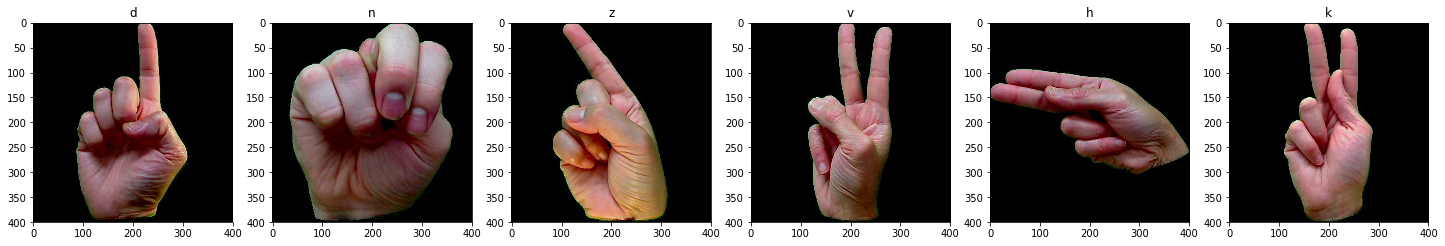

In [18]:
# images before any sort of pre processing

path = "/home/hp/asl_detection_2/asl_alphabets"
folders = os.listdir(path)

fig, ax = matplotlib.pyplot.subplots(nrows=1, ncols=6, figsize=(25,25))
count = 0
for (i,folder) in zip(range(6),folders):
    files = os.listdir(path + '/' + folder)
    
    for file in files:
        img = io.imread(path + '/' + folder + '/' + file)
        ax[i].imshow(img)
        ax[i].set_title(file[6])
        break
    
    count = count +1
    if count==6:
        break
    


In [3]:
# makes new directory

def mkdirp(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

In [4]:
# function for edge detector

def binary_edge_detector(file, folder_path):

    img = cv2.imread(folder_path + '/' + file)
    edges = cv2.Canny(img,100,200)
    directory = "/home/hp/asl_detection_2/asl_preprocess/" + folder_path[-1]
    mkdirp(directory)
    cv2.imwrite(directory + "/" + file + ".png", edges)

In [5]:
# passes all images through the edge detector

path = "/home/hp/asl_detection_2/asl_alphabets"

folders = os.listdir(path)

for folder in folders:
    folder_path = "/home/hp/asl_detection_2/asl_alphabets/" +  folder
    files = os.listdir(folder_path)
    for file in files:
        binary_edge_detector(file, folder_path)

In [6]:
# creates train, validation and test dataset
# 20% images used for test, rest for training
# 25% of trainning dataset used for validation

path = "/home/hp/asl_detection_2/asl_preprocess"

folders = os.listdir(path)
print(folders)

for folder in folders:
    folder_path = "/home/hp/asl_detection_2/asl_preprocess/" +  folder
    print("-----------------------")
    print(folder_path)
    files = os.listdir(folder_path)
    test_size = 0.20*len(files)
    print("-----------------------")
    print(test_size)
    
    for i, file in zip ([item for item in range (int(test_size))], files):
        mkdirp("/home/hp/asl_detection_2/test/unknown")
        destination = "/home/hp/asl_detection_2/test/unknown/" + file
        source = folder_path + '/' + file
        
        os.rename(source, destination)
    
    print("-----------------------")
    
    files = os.listdir(folder_path)
    val_size = 0.25*(len(files))
    print("-----------------------")
    print(val_size)
    files = os.listdir(folder_path)
    for i, file in zip ([item for item in range (int(val_size))], files):
        mkdirp("/home/hp/asl_detection_2/validation/" + folder)
        destination = "/home/hp/asl_detection_2/validation/" + folder + '/' + file
        source = folder_path + '/' + file
        os.rename(source, destination)
    
    
    files = os.listdir(folder_path)
    train_size = len(files)
    print("-----------------------")
    print(train_size)
    print("-----------------------")
    for i, file in zip ([item for item in range (int(train_size))], files):
        mkdirp("/home/hp/asl_detection_2/train/" + folder)
        destination = "/home/hp/asl_detection_2/train/" + folder + '/' + file
        source = folder_path + '/' + file
        os.rename(source, destination)

['d', 'n', 'z', 'v', 'h', 'k', 's', 'x', 'i', 'a', 'b', 'r', 'o', 'q', 'j', 'm', 'c', 'w', 'f', 't', 'e', 'l', 'g', 'p', 'y', 'u']
-----------------------
/home/hp/asl_detection_2/asl_preprocess/d
-----------------------
14.0
-----------------------
-----------------------
14.0
-----------------------
42
-----------------------
-----------------------
/home/hp/asl_detection_2/asl_preprocess/n
-----------------------
14.0
-----------------------
-----------------------
14.0
-----------------------
42
-----------------------
-----------------------
/home/hp/asl_detection_2/asl_preprocess/z
-----------------------
14.0
-----------------------
-----------------------
14.0
-----------------------
42
-----------------------
-----------------------
/home/hp/asl_detection_2/asl_preprocess/v
-----------------------
14.0
-----------------------
-----------------------
14.0
-----------------------
42
-----------------------
-----------------------
/home/hp/asl_detection_2/asl_preprocess/h
-------

In [7]:
source = '/home/hp/asl_detection_2/train/a'
files = os.listdir(source)
img = cv2.imread(source + '/' + files[0])
print(img.shape)
img = np.array (img)
print(img.max())

(400, 400, 3)
255


In [8]:
# renames the folders with integers

def rename_folder(directory, old_folders):
    old_folders.sort()
    for folder, number in zip (old_folders, [item for item in range (0,26)]):
        os.rename(directory + '/' + folder, source + '/' + str(number))


source = '/home/hp/asl_detection_2/train'
folders = os.listdir(source)
rename_folder(source, folders)

source = '/home/hp/asl_detection_2/validation'
folders = os.listdir(source)
rename_folder(source, folders)

In [9]:
def grayscale_train_array(dirc, folder, file):
    img = cv2.imread(dirc + '/' + folder + '/' + file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img,(256, 256))
    return img

In [10]:
train_images = []
train_labels = [] 
val_images = []
val_labels = []

def image_label_create(dirc, folders, images, labels):
    for folder in folders:
        files = os.listdir(dirc + '/' + folder)
        for file in files:
            img = grayscale_train_array(dirc, folder, file)
            images.append(img)
            labels.append(folder) 
    return images, labels       
            

dirc = '/home/hp/asl_detection_2/train'
folders = os.listdir(dirc)
train_images, train_labels = image_label_create(dirc, folders, train_images, train_labels)           
train_images = np.array(train_images, dtype="float") / 255.0  

print(train_images)
print('-------------------------------')
print(train_images.shape)
print('-------------------------------')
print(train_labels)
print('-------------------------------')
print(len(train_labels))

print('===========================================')

dirc = '/home/hp/asl_detection_2/validation'
folders = os.listdir(dirc)
val_images, val_labels = image_label_create(dirc, folders, val_images, val_labels)           
val_images = np.array(val_images, dtype="float") / 255.0  

print(val_images)
print('-------------------------------')
print(val_images.shape)
print('-------------------------------')
print(val_labels)
print('-------------------------------')
print(len(val_labels))

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
----------

In [11]:
train_labels = to_categorical(train_labels)
val_labels = to_categorical(val_labels)

print(train_labels)
print('-------------------------------')
print(len(train_labels))
print('-------------------------------')
print(val_labels)
print('-------------------------------')
print(len(val_labels))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
-------------------------------
1089
-------------------------------
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
-------------------------------
363


In [12]:
#augmentation 

datagen = ImageDataGenerator(
        #rescale=1./255,
        rotation_range=0.2,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        #zoom_range=0.05,
        horizontal_flip=True,
        fill_mode='nearest',
        #validation_split=0.2
)

In [13]:
train_images = train_images.reshape((train_images.shape[0], 256, 256, 1))
val_images = val_images.reshape((val_images.shape[0], 256, 256, 1))

print(train_images.shape)
print(val_images.shape)
print('--------------------------------')
print(train_images)
print('--------------------------------')
print(val_images)

(1089, 256, 256, 1)
(363, 256, 256, 1)
--------------------------------
[[[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
 

In [14]:
#Defining the CNN model


img_rows = 256
img_cols = 256

def get_net():

    inputs = Input((img_rows, img_cols, 1))
    print("inputs shape:",inputs.shape)

    #Normalization layers
    #norm = Lambda(lambda x: x/255.0 -0.5)(inputs)

    #Convolution layers
    conv1 = Conv2D(24, 3, strides=(2, 2), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    print("conv1 shape:",conv1.shape)
      
    conv2 = Conv2D(24, 3, strides=(2, 2), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    print("conv2 shape:",conv2.shape)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv2)
    print("pool1 shape:",pool1.shape)
    
    drop1 = Dropout(0.25)(pool1)

    conv3 = Conv2D(36, 3, strides=(2, 2), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop1)
    print("conv3 shape:",conv3.shape)

    conv4 = Conv2D(36, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    print("conv4 shape:",conv4.shape)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv4)
    print("pool2 shape:",pool2.shape)
    
    drop2 = Dropout(0.25)(pool2)

    conv5 = Conv2D(48, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop2)
    print("conv5 shape:",conv5.shape)
    
    conv6 = Conv2D(48, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    print("conv6 shape:",conv6.shape)
    
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv6)
    print("pool3 shape:",pool3.shape)
    
    drop3 = Dropout(0.25)(pool3)

    #Flattening
    flat = Flatten()(drop3)

    #Fully connected layers
    dense1 = Dense(128, activation = 'relu', use_bias=True, kernel_initializer = 'he_normal')(flat)
    print("dense1 shape:",dense1.shape)
    drop4 = Dropout(0.5)(dense1)

    dense2 = Dense(128, activation = 'relu', use_bias=True, kernel_initializer = 'he_normal')(drop4)
    print("dense2 shape:",dense2.shape)
    drop5 = Dropout(0.5)(dense2)

    '''dense3 = Dense(128, activation = 'relu', use_bias=True, kernel_initializer = 'he_normal')(drop5)
    print("dense3 shape:",dense3.shape)
    drop6 = Dropout(0.25)(dense3)'''

    dense4 = Dense(26, activation = 'softmax', use_bias=True, kernel_initializer = 'he_normal')(drop5)
    print("dense4 shape:",dense4.shape)
    #drop7 = Dropout(0.25)(dense4)
    
    model = Model(input = inputs, output = dense4)

    #model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
                
    optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=0.00000001, decay=0.0)

    #model.compile(optimizer = optimizer, loss = 'mse', metrics=['binary_accuracy'])
    model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

    return model

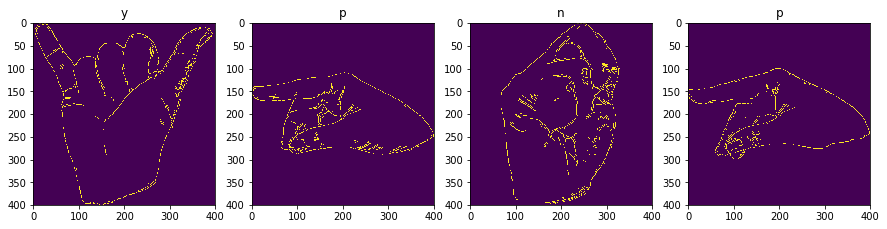

In [6]:
# sample test images

folder = '/home/hp/asl_detection/test/unknown'
files = os.listdir(folder)

count = 0
fig, ax = matplotlib.pyplot.subplots(nrows=1, ncols=4, figsize=(15,15))
for (i, file) in zip(range(4), files):

    img = io.imread(folder + '/' + file)
    #fig0, ax0 = matplotlib.pyplot.subplots(nrows=1, ncols=1, figsize=(3,3))
    ax[i].imshow(img)
    ax[i].set_title(file[6])
    count = count + 1
    
    if count == 4:
        break

In [15]:
folder = '/home/hp/asl_detection/test/unknown'
files = os.listdir(folder)

test_images = []
test_labels = []

for file in files:
    test_labels.append(ord(file[6]) - 97) 
    img = cv2.imread(os.path.join(folder, file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img,(256, 256))
    test_images.append(img)
            
test_images = np.array(test_images, dtype="float") / 255.0  

print(test_images)
print('-------------------------------')
print(test_images.shape)
print('-------------------------------')
print(test_labels)
print('-------------------------------')
print(len(test_labels))

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
----------

In [16]:
test_images = test_images.reshape((test_images.shape[0], 256, 256, 1))
print(test_images.shape)
print(test_images)

(363, 256, 256, 1)
[[[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0

inputs shape: (?, 256, 256, 1)
conv1 shape: (?, 128, 128, 24)
conv2 shape: (?, 64, 64, 24)
pool1 shape: (?, 32, 32, 24)
conv3 shape: (?, 16, 16, 36)
conv4 shape: (?, 16, 16, 36)
pool2 shape: (?, 8, 8, 36)
conv5 shape: (?, 8, 8, 48)
conv6 shape: (?, 8, 8, 48)
pool3 shape: (?, 4, 4, 48)
dense1 shape: (?, 128)
dense2 shape: (?, 128)
dense4 shape: (?, 26)
got model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 256, 256, 1)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 128, 128, 24)      240       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 24)        5208      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 24)        0         
__________________________________________

/home/hp/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:69: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Total params: 179,642
Trainable params: 179,642
Non-trainable params: 0
_________________________________________________________________
Fitting model...
Epoch 1/350
68/68 [==============================] - 82s 1s/step - loss: 3.2759 - acc: 0.0248 - val_loss: 3.2549 - val_acc: 0.0413
Epoch 2/350


/home/hp/anaconda3/envs/tensorflow/lib/python3.5/site-packages/keras/callbacks.py:435: RuntimeWarning: Can save best model only with val_accuracy available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


68/68 [==============================] - 89s 1s/step - loss: 3.2610 - acc: 0.0313 - val_loss: 3.2511 - val_acc: 0.0799
Epoch 3/350
68/68 [==============================] - 97s 1s/step - loss: 3.2416 - acc: 0.0496 - val_loss: 3.1352 - val_acc: 0.0909
Epoch 4/350
68/68 [==============================] - 67s 980ms/step - loss: 3.0273 - acc: 0.1028 - val_loss: 2.8031 - val_acc: 0.1873
Epoch 5/350
68/68 [==============================] - 70s 1s/step - loss: 2.8094 - acc: 0.1046 - val_loss: 2.2876 - val_acc: 0.2342
Epoch 6/350
68/68 [==============================] - 72s 1s/step - loss: 2.6227 - acc: 0.1489 - val_loss: 2.1036 - val_acc: 0.3361
Epoch 7/350
68/68 [==============================] - 77s 1s/step - loss: 2.3759 - acc: 0.2114 - val_loss: 1.8317 - val_acc: 0.4298
Epoch 8/350
68/68 [==============================] - 78s 1s/step - loss: 2.1644 - acc: 0.2592 - val_loss: 1.6706 - val_acc: 0.4215
Epoch 9/350
68/68 [==============================] - 75s 1s/step - loss: 2.0049 - acc: 0.297

68/68 [==============================] - 60s 875ms/step - loss: 0.4493 - acc: 0.8575 - val_loss: 0.1499 - val_acc: 0.9559
Epoch 124/350
68/68 [==============================] - 61s 890ms/step - loss: 0.4503 - acc: 0.8520 - val_loss: 0.1611 - val_acc: 0.9559
Epoch 125/350
68/68 [==============================] - 60s 878ms/step - loss: 0.4150 - acc: 0.8566 - val_loss: 0.1528 - val_acc: 0.9587
Epoch 126/350
68/68 [==============================] - 60s 883ms/step - loss: 0.4608 - acc: 0.8557 - val_loss: 0.1616 - val_acc: 0.9477
Epoch 127/350
68/68 [==============================] - 59s 874ms/step - loss: 0.4202 - acc: 0.8584 - val_loss: 0.1580 - val_acc: 0.9504
Epoch 128/350
68/68 [==============================] - 60s 884ms/step - loss: 0.3805 - acc: 0.8676 - val_loss: 0.1630 - val_acc: 0.9449
Epoch 129/350
68/68 [==============================] - 61s 891ms/step - loss: 0.4065 - acc: 0.8704 - val_loss: 0.1610 - val_acc: 0.9477
Epoch 130/350
68/68 [==============================] - 59s 864

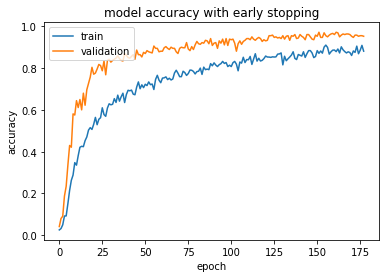

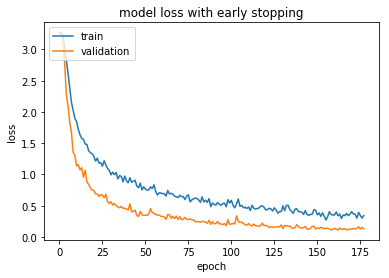

In [23]:
# trains with early stopping

def train():
    
    model = get_net()
    print("got model")
    model.summary()

    
    # early stopping criteria
    es = EarlyStopping(monitor='val_loss', min_delta=0.0001, mode='min', verbose=1, patience=15)
    
    model_checkpoint = ModelCheckpoint('seqnet.hdf5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
    print('Fitting model...')
    
       
    history = model.fit_generator(datagen.flow(train_images, train_labels, batch_size=16),
              validation_data=(val_images, val_labels), 
              steps_per_epoch=len(train_images) // 16,
              epochs=350,
              callbacks=[es, model_checkpoint])

    
    
     
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy with early stopping')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss with early stopping')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show() 
    
    
    return model

model = train()

In [24]:
# save the model to disk
model.save('model_with_early_stopping.h5')

#load the model from disk
#model = load_model('model_latest.h5') 

y_proba = model.predict(test_images)
print(y_proba)
print('--------------------------------')
print(len(y_proba))
print('--------------------------------')
print(len(y_proba[0]))
print('--------------------------------')
y_classes = y_proba.argmax(axis=-1)
print("________________Predicted classes________________")
print(y_classes)
print('--------------------------------')
print(len(y_classes))
print('--------------------------------')


[[2.13186108e-10 2.13371484e-30 1.76184240e-28 ... 3.06247405e-30
  9.99998569e-01 1.13461714e-23]
 [6.93688948e-17 5.88399678e-20 1.41698770e-14 ... 3.49431645e-19
  3.18905768e-09 8.55841301e-11]
 [3.00573556e-05 8.11530481e-06 2.64593800e-05 ... 1.30931484e-02
  1.21971784e-08 1.97225305e-07]
 ...
 [3.45958458e-16 2.33072676e-13 2.38783636e-14 ... 1.96580084e-13
  2.88979073e-13 2.38219881e-03]
 [7.88769394e-05 4.25587384e-15 1.22019487e-13 ... 7.31027283e-09
  1.14031636e-05 1.52337449e-07]
 [3.02949820e-06 1.34609020e-16 8.40362563e-16 ... 9.69122699e-11
  2.47575917e-06 1.99953849e-08]]
--------------------------------
363
--------------------------------
26
--------------------------------
________________Predicted classes________________
[24 15 13 15  6 12 23  5 18 20 24  5 18  4 25 22 15  7 13 19  2  9  3  0
 20 13 11 25  9  3  4 21 22  1 10 13  1  1  9  4 12 18 13 25  4 24 18 24
 18 25  1 23  4  1 16 18  6  2  1 18  3  1 19  7 15 23 11  8  3 20 13 17
  4 15  7 22 17  7  9  3 

In [25]:
acc = accuracy_score(test_labels, y_classes) * 100
print("Accuracy on test set : {} %".format(acc))
print('--------------------------------------------------')

Accuracy on test set : 96.69421487603306 %
--------------------------------------------------


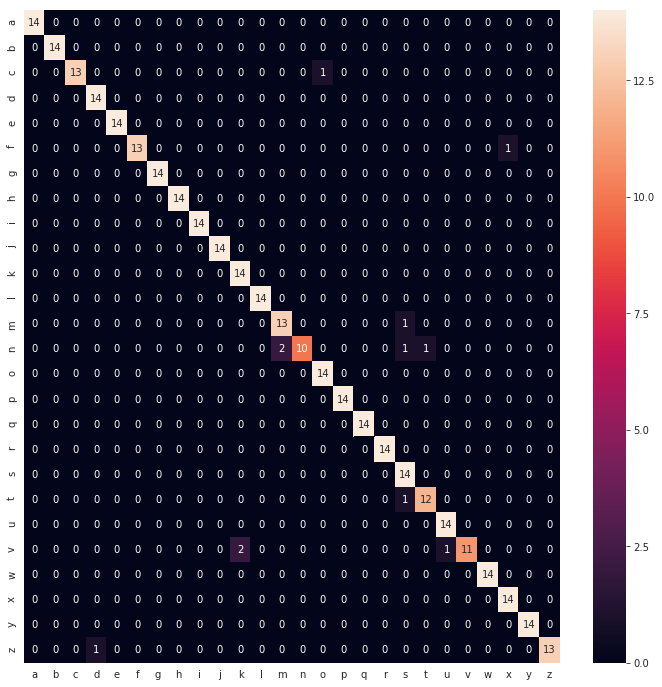

In [26]:
cm = confusion_matrix(test_labels, y_classes, binary=False)

labels = list(string.ascii_lowercase)
#print(labels)

with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(12, 12))
    ax = sns.heatmap(cm, annot=True)
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)

In [27]:
classwise_prediction_accuracy = cm.diagonal()/cm.sum(axis=1)
print("____________Class wise prediction accuracies_____________")
dict(zip(list(string.ascii_lowercase), classwise_prediction_accuracy))

____________Class wise prediction accuracies_____________


{'a': 1.0,
 'b': 1.0,
 'c': 0.9285714285714286,
 'd': 1.0,
 'e': 1.0,
 'f': 0.9285714285714286,
 'g': 1.0,
 'h': 1.0,
 'i': 1.0,
 'j': 1.0,
 'k': 1.0,
 'l': 1.0,
 'm': 0.9285714285714286,
 'n': 0.7142857142857143,
 'o': 1.0,
 'p': 1.0,
 'q': 1.0,
 'r': 1.0,
 's': 1.0,
 't': 0.9230769230769231,
 'u': 1.0,
 'v': 0.7857142857142857,
 'w': 1.0,
 'x': 1.0,
 'y': 1.0,
 'z': 0.9285714285714286}

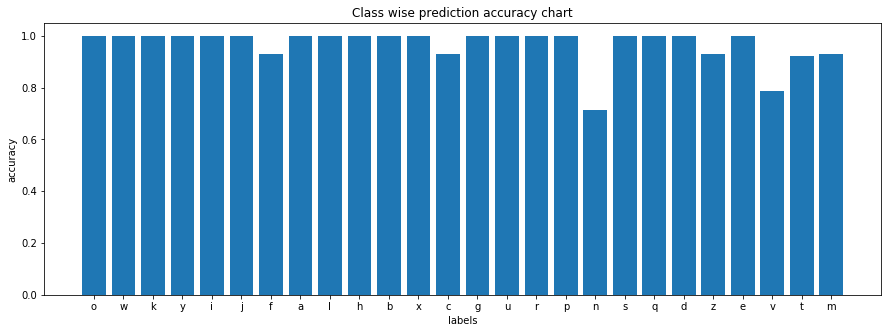

In [28]:
D = dict(zip(list(string.ascii_lowercase), classwise_prediction_accuracy))

plt.figure(figsize=(15,5))
plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()))
#plt.xticks(range(len(D)), list(string.ascii_lowercase))
plt.title('Class wise prediction accuracy chart')
plt.ylabel('accuracy')
plt.xlabel('labels')
plt.show()

inputs shape: (?, 256, 256, 1)
conv1 shape: (?, 128, 128, 24)
conv2 shape: (?, 64, 64, 24)
pool1 shape: (?, 32, 32, 24)
conv3 shape: (?, 16, 16, 36)
conv4 shape: (?, 16, 16, 36)
pool2 shape: (?, 8, 8, 36)
conv5 shape: (?, 8, 8, 48)
conv6 shape: (?, 8, 8, 48)
pool3 shape: (?, 4, 4, 48)
dense1 shape: (?, 128)
dense2 shape: (?, 128)
dense4 shape: (?, 26)


/home/hp/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:69: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


got model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 24)      240       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 24)        5208      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 24)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 24)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 36)        7812      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 36)        11700     


/home/hp/anaconda3/envs/tensorflow/lib/python3.5/site-packages/keras/callbacks.py:435: RuntimeWarning: Can save best model only with val_accuracy available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


68/68 [==============================] - 81s 1s/step - loss: 3.2357 - acc: 0.0487 - val_loss: 3.0732 - val_acc: 0.0716
Epoch 3/350
68/68 [==============================] - 84s 1s/step - loss: 3.0759 - acc: 0.0781 - val_loss: 2.8724 - val_acc: 0.1129
Epoch 4/350
68/68 [==============================] - 62s 905ms/step - loss: 2.9668 - acc: 0.0800 - val_loss: 2.7206 - val_acc: 0.1240
Epoch 5/350
68/68 [==============================] - 62s 909ms/step - loss: 2.8185 - acc: 0.0928 - val_loss: 2.5968 - val_acc: 0.1846
Epoch 6/350
68/68 [==============================] - 62s 906ms/step - loss: 2.6776 - acc: 0.1278 - val_loss: 2.2208 - val_acc: 0.3003
Epoch 7/350
68/68 [==============================] - 61s 897ms/step - loss: 2.4947 - acc: 0.1756 - val_loss: 2.1103 - val_acc: 0.3251
Epoch 8/350
68/68 [==============================] - 62s 906ms/step - loss: 2.3622 - acc: 0.1857 - val_loss: 1.8687 - val_acc: 0.4463
Epoch 9/350
68/68 [==============================] - 61s 898ms/step - loss: 2.18

68/68 [==============================] - 64s 941ms/step - loss: 0.7722 - acc: 0.7306 - val_loss: 0.3893 - val_acc: 0.8843
Epoch 64/350
68/68 [==============================] - 63s 929ms/step - loss: 0.8005 - acc: 0.7318 - val_loss: 0.3714 - val_acc: 0.9063
Epoch 65/350
68/68 [==============================] - 63s 923ms/step - loss: 0.7203 - acc: 0.7463 - val_loss: 0.3333 - val_acc: 0.9036
Epoch 66/350
68/68 [==============================] - 64s 938ms/step - loss: 0.6748 - acc: 0.7647 - val_loss: 0.3153 - val_acc: 0.9091
Epoch 67/350
68/68 [==============================] - 64s 937ms/step - loss: 0.6982 - acc: 0.7573 - val_loss: 0.3863 - val_acc: 0.8788
Epoch 68/350
68/68 [==============================] - 64s 948ms/step - loss: 0.7109 - acc: 0.7527 - val_loss: 0.3367 - val_acc: 0.9174
Epoch 69/350
68/68 [==============================] - 63s 927ms/step - loss: 0.7507 - acc: 0.7189 - val_loss: 0.3523 - val_acc: 0.8843
Epoch 70/350
68/68 [==============================] - 63s 924ms/step

68/68 [==============================] - 62s 907ms/step - loss: 0.3366 - acc: 0.8934 - val_loss: 0.1148 - val_acc: 0.9559
Epoch 184/350
68/68 [==============================] - 61s 902ms/step - loss: 0.3005 - acc: 0.9007 - val_loss: 0.1102 - val_acc: 0.9504
Epoch 185/350
68/68 [==============================] - 62s 906ms/step - loss: 0.2890 - acc: 0.8952 - val_loss: 0.1071 - val_acc: 0.9587
Epoch 186/350
68/68 [==============================] - 61s 897ms/step - loss: 0.2989 - acc: 0.9026 - val_loss: 0.1248 - val_acc: 0.9532
Epoch 187/350
68/68 [==============================] - 60s 888ms/step - loss: 0.3557 - acc: 0.8906 - val_loss: 0.1110 - val_acc: 0.9587
Epoch 188/350
68/68 [==============================] - 61s 899ms/step - loss: 0.3578 - acc: 0.8842 - val_loss: 0.1122 - val_acc: 0.9587
Epoch 189/350
68/68 [==============================] - 61s 904ms/step - loss: 0.3770 - acc: 0.8770 - val_loss: 0.1042 - val_acc: 0.9669
Epoch 190/350
68/68 [==============================] - 61s 893

Epoch 244/350
68/68 [==============================] - 82s 1s/step - loss: 0.2779 - acc: 0.9081 - val_loss: 0.0743 - val_acc: 0.9669
Epoch 245/350
68/68 [==============================] - 75s 1s/step - loss: 0.2804 - acc: 0.9117 - val_loss: 0.0830 - val_acc: 0.9697
Epoch 246/350
68/68 [==============================] - 73s 1s/step - loss: 0.3236 - acc: 0.8798 - val_loss: 0.1222 - val_acc: 0.9587
Epoch 247/350
68/68 [==============================] - 89s 1s/step - loss: 0.3178 - acc: 0.9145 - val_loss: 0.0855 - val_acc: 0.9725
Epoch 248/350
68/68 [==============================] - 99s 1s/step - loss: 0.2851 - acc: 0.9072 - val_loss: 0.0727 - val_acc: 0.9780
Epoch 249/350
68/68 [==============================] - 89s 1s/step - loss: 0.2857 - acc: 0.9117 - val_loss: 0.0950 - val_acc: 0.9725
Epoch 250/350
68/68 [==============================] - 86s 1s/step - loss: 0.3722 - acc: 0.8824 - val_loss: 0.0838 - val_acc: 0.9697
Epoch 251/350
68/68 [==============================] - 78s 1s/step - 

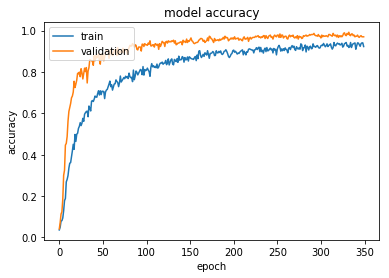

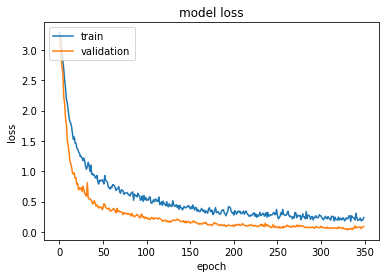

In [17]:
# trains without early stopping


def train():
    
    model = get_net()
    print("got model")
    model.summary()

    
    model_checkpoint = ModelCheckpoint('seqnet.hdf5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
    print('Fitting model...')
    
       
    history = model.fit_generator(datagen.flow(train_images, train_labels, batch_size=16),
              validation_data=(val_images, val_labels), 
              steps_per_epoch=len(train_images) // 16,
              epochs=350,
              callbacks=[model_checkpoint])

    
    
    
     
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show() 
    
    
    return model

model = train()

In [18]:
# save the model to disk
model.save('model_with_long_training.h5')

#load the model from disk
#model = load_model('model_latest.h5') 

y_proba = model.predict(test_images)
print(y_proba)
print('--------------------------------')
print(len(y_proba))
print('--------------------------------')
print(len(y_proba[0]))
print('--------------------------------')
y_classes = y_proba.argmax(axis=-1)
print("________________Predicted classes________________")
print(y_classes)
print('--------------------------------')
print(len(y_classes))
print('--------------------------------')

[[3.9653458e-13 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  1.0000000e+00 8.3309612e-32]
 [0.0000000e+00 0.0000000e+00 6.1222726e-34 ... 0.0000000e+00
  1.7455183e-17 6.9089193e-27]
 [5.1222014e-07 1.6399554e-13 4.3040291e-06 ... 1.3425545e-05
  5.2646509e-09 2.0147832e-10]
 ...
 [2.9920292e-20 5.9399318e-19 5.2286587e-16 ... 1.0231472e-16
  6.2656846e-12 5.3699716e-04]
 [1.4160163e-10 2.5697782e-25 1.7394499e-24 ... 2.1639416e-21
  7.3763162e-10 1.9817077e-13]
 [5.1633611e-11 3.2348182e-22 4.9585976e-23 ... 3.6589110e-20
  3.9957588e-09 6.9279435e-12]]
--------------------------------
363
--------------------------------
26
--------------------------------
________________Predicted classes________________
[24 15 13 15  6 12 23  5 18 20 24  5 18  4 25 22 15  7 13 19  2  9  3  0
 20 13 11 25  9  3  4 21 22  1 10 13  1  1  9  4 12 19 13 25  4 24 18 24
 18 25  1 23  4  1 16 12  6  2  1 18  3  1 19  7 15 23 11  8  3 21 13 17
  4 15  7 22 17  7  9  3  1  7 10  1 25  1 24  3 19 16 24 23 

In [19]:
acc = accuracy_score(test_labels, y_classes) * 100
print("Accuracy on test set : {} %".format(acc))
print('--------------------------------------------------')

Accuracy on test set : 97.7961432506887 %
--------------------------------------------------


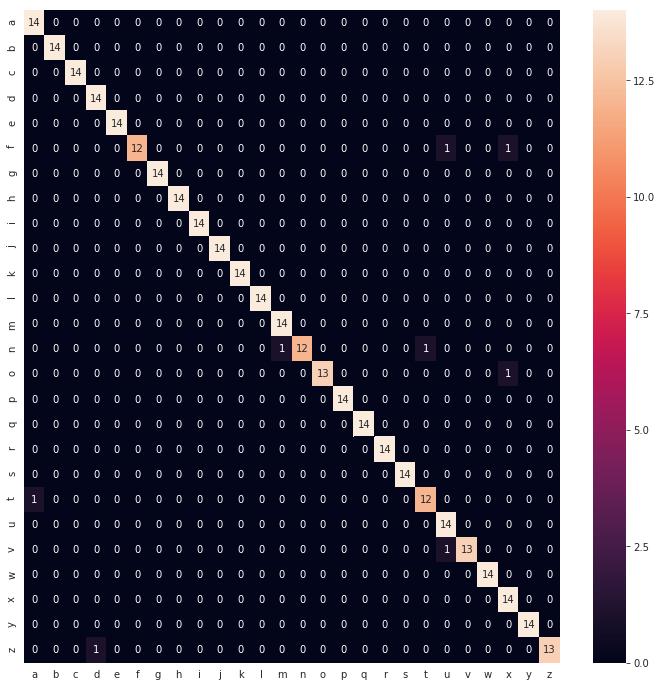

In [20]:
cm = confusion_matrix(test_labels, y_classes, binary=False)

labels = list(string.ascii_lowercase)
#print(labels)

with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(12, 12))
    ax = sns.heatmap(cm, annot=True)
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)

In [21]:
classwise_prediction_accuracy = cm.diagonal()/cm.sum(axis=1)
print("____________Class wise prediction accuracies_____________")
dict(zip(list(string.ascii_lowercase), classwise_prediction_accuracy))

____________Class wise prediction accuracies_____________


{'a': 1.0,
 'b': 1.0,
 'c': 1.0,
 'd': 1.0,
 'e': 1.0,
 'f': 0.8571428571428571,
 'g': 1.0,
 'h': 1.0,
 'i': 1.0,
 'j': 1.0,
 'k': 1.0,
 'l': 1.0,
 'm': 1.0,
 'n': 0.8571428571428571,
 'o': 0.9285714285714286,
 'p': 1.0,
 'q': 1.0,
 'r': 1.0,
 's': 1.0,
 't': 0.9230769230769231,
 'u': 1.0,
 'v': 0.9285714285714286,
 'w': 1.0,
 'x': 1.0,
 'y': 1.0,
 'z': 0.9285714285714286}

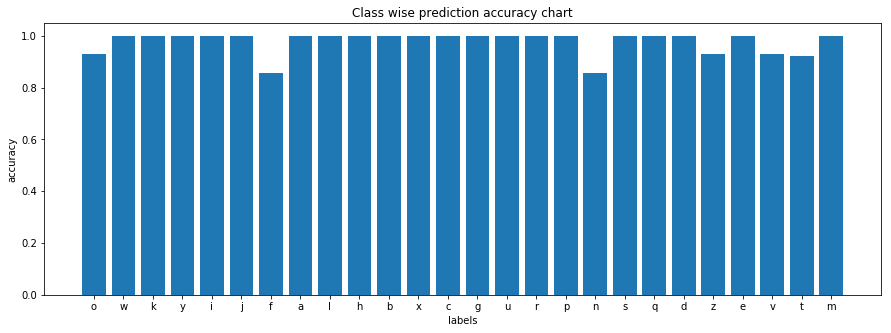

In [22]:
D = dict(zip(list(string.ascii_lowercase), classwise_prediction_accuracy))

plt.figure(figsize=(15,5))
plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()))
#plt.xticks(range(len(D)), list(string.ascii_lowercase))
plt.title('Class wise prediction accuracy chart')
plt.ylabel('accuracy')
plt.xlabel('labels')
plt.show()